# Using Julia via pyjulia

This notebook demonstrates the application of pyPESTO to objective functions defined in [Julia](https://julialang.org/).

As demonstration example, we use an [SIR disease dynamcis model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology). For simulation, we use [DifferentialEquations.jl](https://diffeq.sciml.ai/stable/).

The code consists of multiple functions in the file `model_julia/SIR.jl`, wrapped in the namespace of a module `SIR`. We first speficy the reaction network via `Catalyst`, and then translate them to an ordinary differential equation (ODE) model in `OrdinaryDiffEq`. Then, we create synthetic observed `data` with normal noise. After that, we define a quadratic cost function `fun` (the log-likelihood under an additive normal noise model). We use backwards automatic differentiation via `Zygote` to derive also the gradient `grad`:

In [1]:
from pypesto.objective.julia import display_source_ipython

display_source_ipython("model_julia/SIR.jl")

We make the cost function and gradient known to `JuliaObjective`. Importing module and dependencies, and initializing some operations, can take some time due to pre-processing.

In [2]:
import pypesto
from pypesto.objective.julia import JuliaObjective

In [3]:
%%time

obj = JuliaObjective(
    module="SIR",
    source_file="model_julia/SIR.jl",
    fun="fun",
    grad="grad",
)

CPU times: user 1min 26s, sys: 3.39 s, total: 1min 29s
Wall time: 1min 31s


That's it -- now we have an objective function that we can simply use in pyPESTO like any other. Internally, it delegates all calls to Julia and translates results.

## Comments

Before continuing with the workflow, some comments:

When calling a function for the first time, Julia performs some internal pre-processing. Subsequent function calls are much more efficient.

In [4]:
import numpy as np

x = np.array([-4.0, -2.0])

%time print(obj.get_fval(x))
%time print(obj.get_fval(x))
%time print(obj.get_grad(x))
%time print(obj.get_grad(x))

23.12228487889986
CPU times: user 963 ms, sys: 15.9 ms, total: 979 ms
Wall time: 969 ms
23.12228487889986
CPU times: user 222 µs, sys: 13 µs, total: 235 µs
Wall time: 157 µs
[-38.6806348  19.9557434]
CPU times: user 1min 17s, sys: 1.68 s, total: 1min 18s
Wall time: 1min 17s
[-38.6806348  19.9557434]
CPU times: user 1.15 ms, sys: 0 ns, total: 1.15 ms
Wall time: 1.15 ms


The outputs are already numpy arrays (in custom Julia objectives, it needs to be made sure that return objects can be parsed to floats and numpy arrays in Python).

In [5]:
type(obj.get_grad(x))

numpy.ndarray

Here, we use backward automatic differentiation to calculate the gradient. We can verify its correctness via finite difference checks:

In [6]:
from pypesto import FD

fd = FD(obj, grad=True)

fd.get_grad(x)

array([-38.75164238,  19.9661208 ])

Further, we can use the `JuliaObjective.get()` function to directly access any variable in the Julia module:

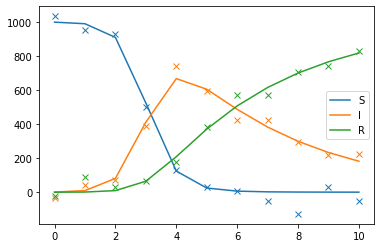

In [7]:
sol_true = np.asarray(obj.get("sol_true"))
data = obj.get("data")

import matplotlib.pyplot as plt

for i, label in zip(range(3), ["S", "I", "R"]):
    plt.plot(sol_true[i], color=f"C{i}", label=label)
    plt.plot(data[i], 'x', color=f"C{i}")
plt.legend();

## Inference problem

Let us define an inference problem by specifying parameter bounds. Note that we use a log10-transformation of parameters in `fun`.

In [8]:
from pypesto import Problem

# parameter boundaries
lb, ub = [-5.0, -3.0], [-3.0, -1.0]

# estimation problem
problem = Problem(obj, lb=lb, ub=ub)

## Optimization

Let us perform an optimization:

In [9]:
%%time

# optimize
from pypesto import optimize

result = optimize.minimize(problem)

100%|███████████████████████████████████████| 100/100 [00:01<00:00, 77.33it/s]


CPU times: user 1.4 s, sys: 108 ms, total: 1.51 s
Wall time: 1.49 s


The objective function evaluations are quite fast!

We can also use parallelization, by passing a `pypesto.engine.MultiProcessEngine` to the `minimize` function.

In [10]:
%%time

from pypesto.engine import MultiProcessEngine

engine = MultiProcessEngine()
result = optimize.minimize(problem, engine=engine, n_starts=100)

Engine set up to use up to 8 processes in total. The number was automatically determined and might not be appropriate on some systems.
2022-09-06 22:12:51,245 - pypesto.engine.multi_process - WARNING - Engine set up to use up to 8 processes in total. The number was automatically determined and might not be appropriate on some systems.
Performing parallel task execution on 8 processes.
2022-09-06 22:12:51,260 - pypesto.engine.multi_process - INFO - Performing parallel task execution on 8 processes.
100%|██████████████████████████████████████| 100/100 [00:00<00:00, 303.89it/s]


CPU times: user 337 ms, sys: 173 ms, total: 509 ms
Wall time: 1.37 s


2022-09-06 22:12:52,637 - py.warnings - WARNING - /home/yannik/env/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



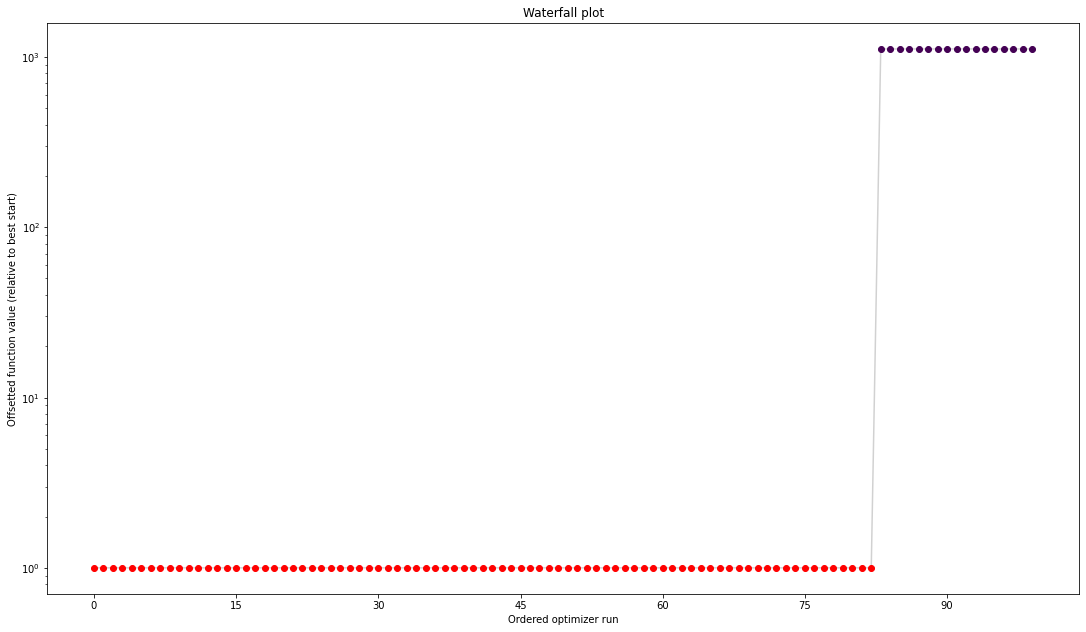

In [11]:
from pypesto import visualize

visualize.waterfall(result);

## Sampling

Last, let us perform sampling from the log-posterior with implicitly defined uniform prior via the parameter bounds:

In [12]:
%%time

from pypesto import sample

sampler = sample.AdaptiveParallelTemperingSampler(
    internal_sampler=sample.AdaptiveMetropolisSampler(), n_chains=3
)

result = sample.sample(
    problem, n_samples=10000, sampler=sampler, result=result
)

100%|█████████████████████████████████| 10000/10000 [00:09<00:00, 1042.06it/s]
Elapsed time: 9.636899520000014
2022-09-06 22:13:02,904 - pypesto.sample.sample - INFO - Elapsed time: 9.636899520000014


CPU times: user 9.46 s, sys: 256 ms, total: 9.72 s
Wall time: 9.68 s


Geweke burn-in index: 0
2022-09-06 22:13:03,051 - pypesto.sample.diagnostics - INFO - Geweke burn-in index: 0


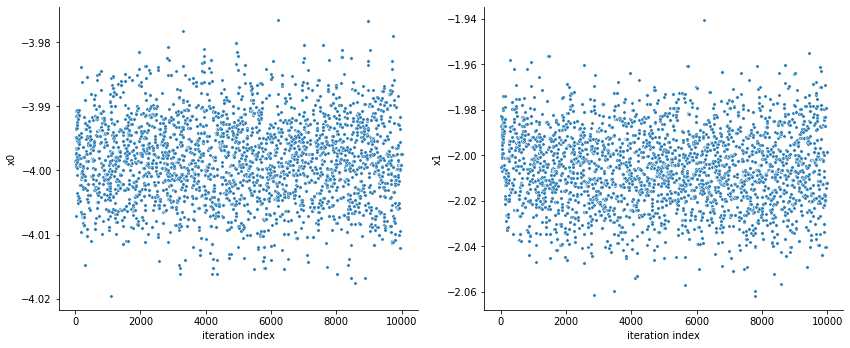

In [13]:
pypesto.sample.geweke_test(result)
visualize.sampling_parameter_traces(
    result, use_problem_bounds=False, size=(12, 5)
);

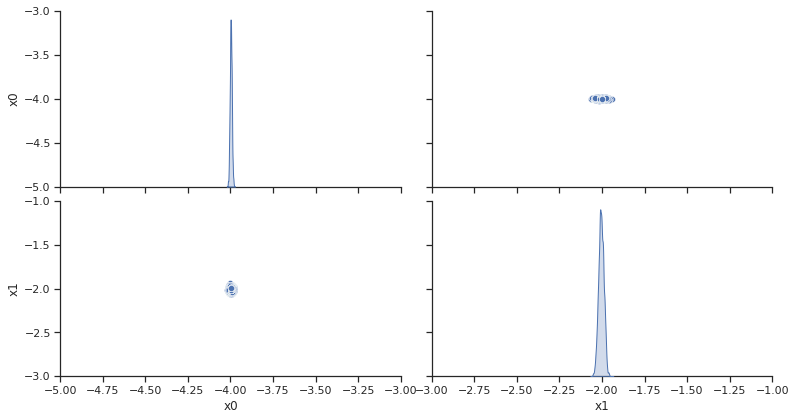

In [14]:
visualize.sampling_scatter(result, size=[13, 6]);